In [1]:
import pickle
import pandas as pd
import torch
import matplotlib.pyplot as plt

import python.voxels as voxels
import python.RNN as RNN
import python.clustering as cl
import python.display as dp

graph_size = (20,8)

project_folder = "veleval"

use_road_network = True

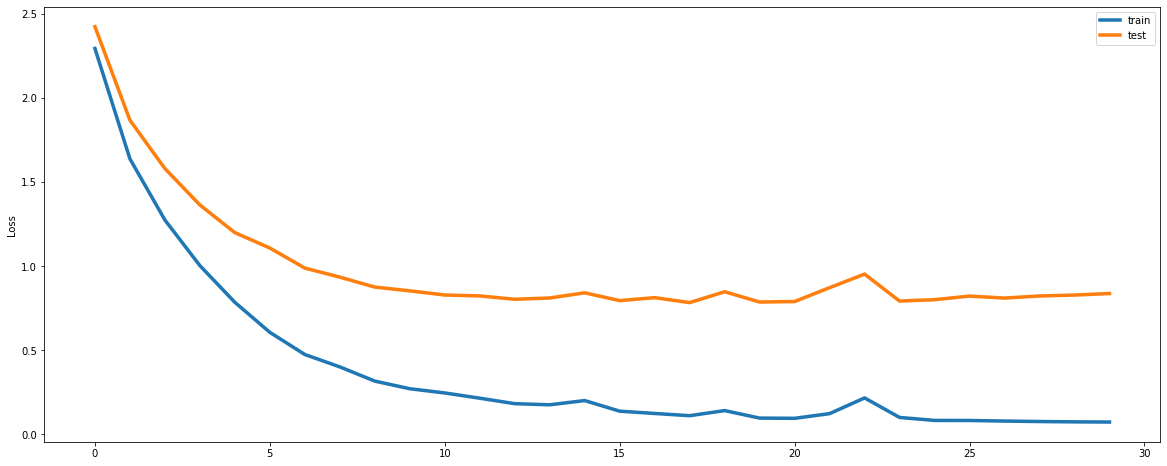

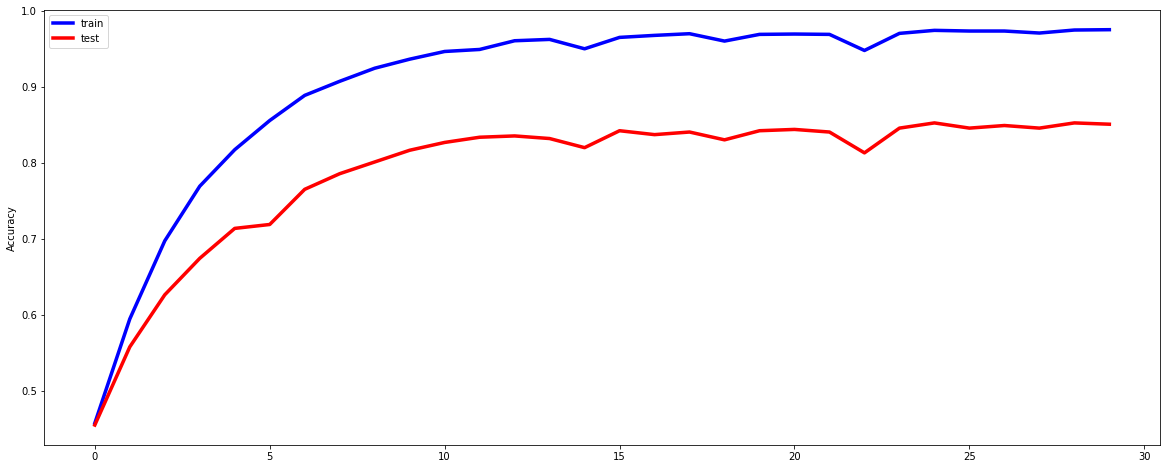

In [2]:
with open("./files/"+project_folder+"/neural_networks/saved/predict.tab",'rb') as infile:
    tab_predict = pickle.load(infile)
with open("./files/"+project_folder+"/neural_networks/saved/loss.tab",'rb') as infile:
    tab_loss = pickle.load(infile)
    
fig = plt.figure(figsize=graph_size)
plt.plot(tab_loss[0], label='train', linewidth=3.5)
plt.plot(tab_loss[1], label='test', linewidth=3.5)
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

fig = plt.figure(figsize=graph_size)
plt.plot(tab_predict[0], color='blue', label='train', linewidth=3.5)
plt.plot(tab_predict[1], color='red', label='test', linewidth=3.5)
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [3]:
with open("./files/"+project_folder+"/data_processed/osmnx_pathfinding_simplified.df",'rb') as infile:
    df_pathfinding = pickle.load(infile)
with open("./files/"+project_folder+"/clustering/dbscan_observations.tab",'rb') as infile:
    tab_clusters = pickle.load(infile)
with open("./files/"+project_folder+"/clustering/voxels_clustered_osmnx.dict",'rb') as infile:
    dict_voxels = pickle.load(infile)
with open("./files/"+project_folder+"/neural_networks/saved/network.param",'rb') as infile:
    param = pickle.load(infile)
with open("./files/"+project_folder+"/neural_networks/saved/num_test.tab",'rb') as infile:
    tab_num_test = pickle.load(infile)
    

size_data = 1

df = df_pathfinding

tab_routes_voxels, _, _ = voxels.generate_voxels(df, df.iloc[0]["route_num"], df.iloc[-1]["route_num"])
tab_routes_voxels_int = []


dict_clusters = cl.tab_clusters_to_dict(tab_clusters)

network = RNN.RNN_LSTM(size_data, max(tab_clusters)+1, param.hidden_size, param.num_layers, param.bidirectional, param.dropout)
network.load_state_dict(torch.load("files/"+project_folder+"/neural_networks/saved/network_temp.pt"))
network.eval()


RNN_LSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True)
  (out1): Linear(in_features=256, out_features=143, bias=True)
  (out2): Linear(in_features=128, out_features=143, bias=True)
  (out3): Linear(in_features=128, out_features=143, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0, inplace=False)
)

In [4]:
tab_results = []
tab_routes_voxels_int = []
for i in range(len(tab_routes_voxels)):
    nb_vox = 0
    tab_routes_voxels_int.append([])
    route = tab_routes_voxels[i]
    for vox in route:
        if(nb_vox%param.voxels_frequency==0): #(len(tab_routes_voxels_int[i])==0 or tab_routes_voxels_int[i][-1][0] != dict_voxels[vox]["cluster"]): 
            points = [dict_voxels[vox]["cluster"]+1]
            tab_routes_voxels_int[i].append(points)
        nb_vox += 1
    tab_routes_voxels_int[i] = torch.Tensor(tab_routes_voxels_int[i])
data = tab_routes_voxels_int #torch.nn.utils.rnn.pad_sequence(tab_routes_voxels_int, batch_first=True)

In [5]:
nb_prediction_test = 0
nb_good_prediction_test = 0
nb_prediction_train = 0
nb_good_prediction_train = 0

tab_results_test = []
tab_results_train = []

for i in range(len(data)):

    if(tab_clusters[i] != -1):
        tens_route = data[i].unsqueeze(0)
        target = torch.LongTensor(tab_clusters[i])
        output = network(tens_route)
        pred = output.argmax(dim=1, keepdim=True)


        if(i in tab_num_test):
            tab_results_test.append({"probabilities": output.squeeze(), "good_result": pred==tab_clusters[i],
                                     "cluster": tab_clusters[i]})
            nb_prediction_test+=1
            if(pred==tab_clusters[i]):
                nb_good_prediction_test+=1
        else:
            tab_results_train.append({"probabilities": output.squeeze(), "good_result": pred==tab_clusters[i],
                         "cluster": tab_clusters[i]})
            nb_prediction_train+=1
            if(pred==tab_clusters[i]):
                nb_good_prediction_train+=1
    
            
print("Good train predict:", nb_good_prediction_train/nb_prediction_train*100, "%")
print("Good test predict:", nb_good_prediction_test/nb_prediction_test*100, "%")

Good train predict: 97.52759381898454 %
Good test predict: 85.07718696397941 %


In [6]:
tab_success_train = []
tab_fail_train = []

tab_success_test = []
tab_fail_test = []

for res in tab_results_train:
    if(res["good_result"]):
        tab_success_train.append(res["cluster"])
    else:
        tab_fail_train.append(res["cluster"])
        
for res in tab_results_test:
    if(res["good_result"]):
        tab_success_test.append(res["cluster"])
    else:
        tab_fail_test.append(res["cluster"])




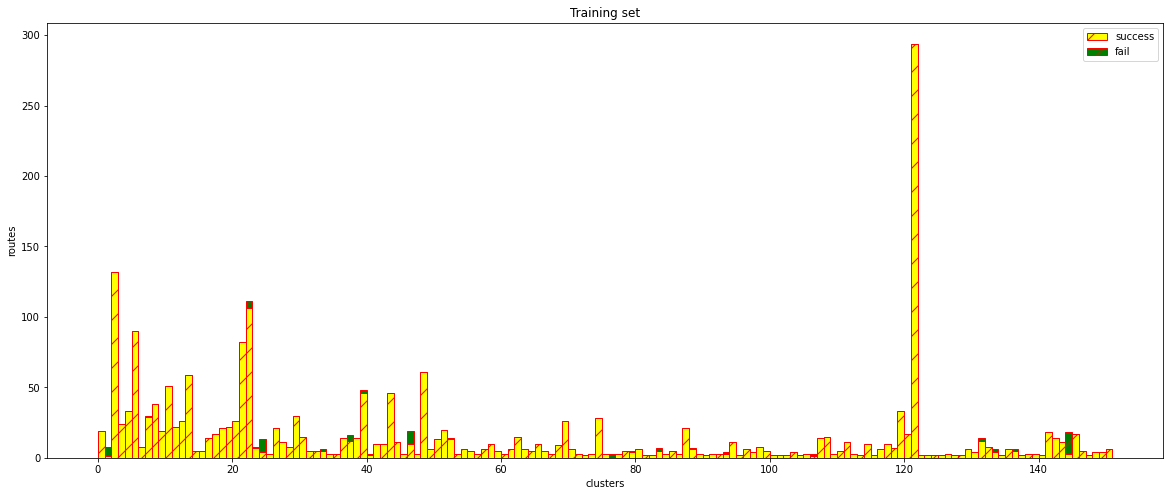

In [7]:
fig = plt.figure(figsize=graph_size)
plt.hist([tab_success_train, tab_fail_train],range(0, max(tab_clusters)+2), color = ['yellow', 'green'],
            edgecolor = 'red', hatch = '/', label = ['success', 'fail'],
            histtype = 'barstacked')
plt.ylabel('routes')
plt.xlabel('clusters')
plt.title('Training set')
plt.legend()

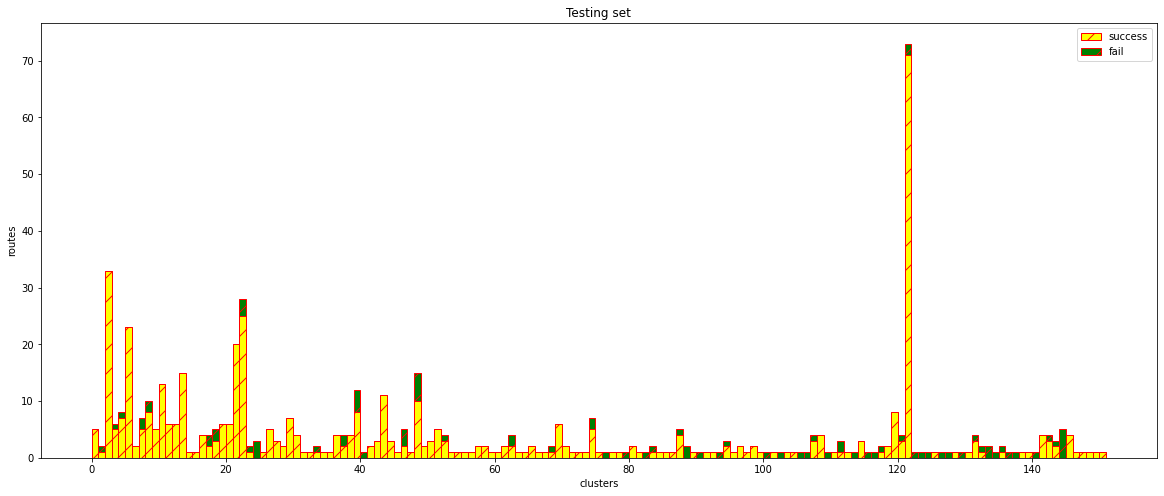

In [8]:
fig = plt.figure(figsize=graph_size)
plt.hist([tab_success_test, tab_fail_test],range(0, max(tab_clusters)+2), color = ['yellow', 'green'],
            edgecolor = 'red', hatch = '/', label = ['success', 'fail'],
            histtype = 'barstacked')
plt.ylabel('routes')
plt.xlabel('clusters')
plt.title('Testing set')
plt.legend()

In [9]:
prob_fail_train = []
prob_fail_test = []


for res in tab_results_train:
    if(not (res["good_result"])):
        prob_fail_train.append([])
        for i in range(len(res["probabilities"].tolist())):
            prob_fail_train[-1].append(10**res["probabilities"].tolist()[i])

for res in tab_results_test:
    if(not(res["good_result"])):
        prob_fail_test.append([])
        for i in range(len(res["probabilities"].tolist())):
            prob_fail_test[-1].append(10**res["probabilities"].tolist()[i])

[]

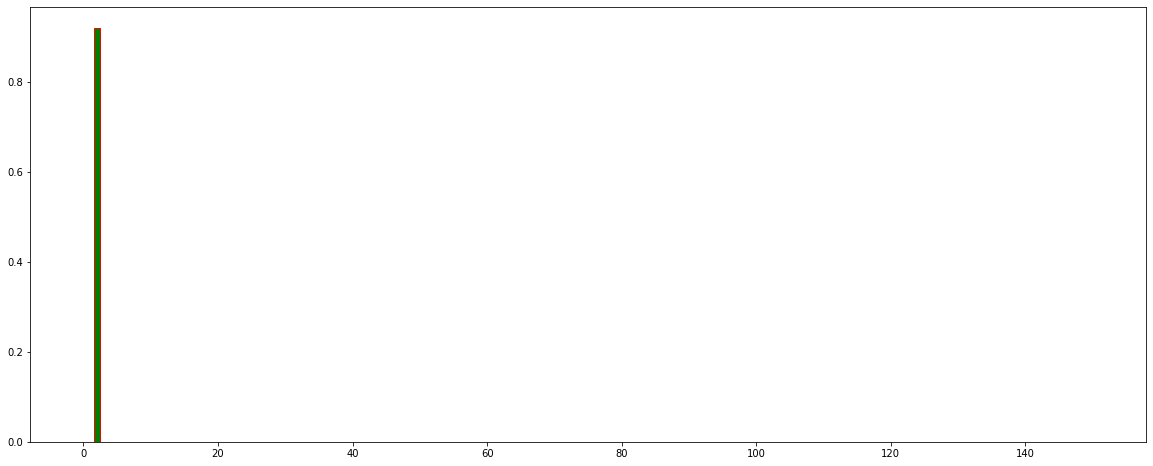

In [10]:
num_fail = 2
#print(prob_fail_test[num_fail])
fig = plt.figure(figsize=graph_size)
plt.bar(range(len(prob_fail_test[num_fail])), prob_fail_test[num_fail], color='green', edgecolor = 'red')
plt.plot()